# Causal effect estimation with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results. This class extends the class towards causal effect estimation including the reconstruction of optimal adjustment sets.

Optimal adjustment theory is described here:
J. Runge,
Necessary and sufficient graphical conditions for optimal adjustment sets in causal graphical models with hidden variables 
NeurIPS 2021

## 1. Estimating linear directed link effects

In [102]:
# Imports

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import Models

Consider time series coming from a data generating process

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + 0.5 X^1_{t-2} + 0.6 X^3_{t-3} + \eta^2_t\\
X^3_t &= 0.7 X^3_{t-1} + \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable. In Tigramite such a process can be generated with the function ``pp.var_process``.

In [103]:
def lin(x): return x
def nonlin(x): return x**3
links = {0: [((0, -1), 0.7, lin), ((1, -1), -0.8, lin)],
         1: [((1, -1), 0.8, lin), ((3, -1), 0.8, lin)],
         2: [((2, -1), 0.5, lin), ((1, -2), 0.5, lin), ((3, -3), 0.6, lin)],
         3: [((3, -1), 0.4, lin)],
         }
T = 10000     # time series length
data, _ = pp.structural_causal_process(links, T=T, seed=42)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)


First, we plot the time series. This can be done with the function ``tp.plot_timeseries``

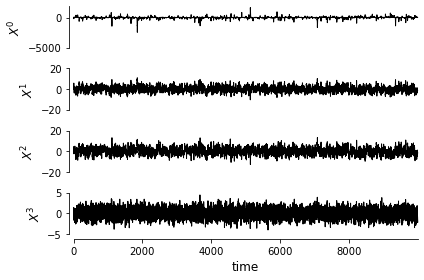

In [104]:
tp.plot_timeseries(dataframe); plt.show()

It's stationary and doesn't contain missing values (covered in other tutorial). 
In this tutorial, we assume that the true graph is known and the user wants to estimate causal effects using backdoor adjustment:

SOME FORMULAS...

This first part covers the case where the user specifies the adjustment set herself.

First, we initialize the ``Models`` class with a ``dataframe`` and a sklearn ``model`` object, here linear regression. Here we leave the data as it is and perform no standardization, which could be done with ``data_transform``. ``mask_type`` can be used for masking data samples (e.g., winter months).

In [54]:
model = Models(
        dataframe=dataframe, 
        model=sklearn.linear_model.LinearRegression(),
        data_transform=None,   #sklearn.preprocessing.StandardScaler(),
        mask_type=None,
        verbosity=1)

First suppose we are given a DAG and know the parents of all variables (incl. time lags). We can then estimate the linear coefficients for each link.
Before running the causal algorithm, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.

In [55]:
all_parents = {0: [(0, -1), (1, -1)],
               1: [(1, -1), (3, -1)],
               2: [(2, -1), (1, -2), (3, -3)],
               3: [(3, -1)],
               }
fit_results = model.get_fit(all_parents=all_parents,
                selected_variables=None,
                tau_max=None,
                cut_off='max_lag_or_tau_max',
                return_data=False)

The fitted sklearn models are stored in a dictionary. For the linear case we are interested in the regression coefficients which we can retrieve as follows.

In [56]:
coefs = model.get_coefs()
print(coefs)

{0: {(0, -1): 0.70000273, (1, -1): -0.8005577}, 1: {(1, -1): 0.79954785, (3, -1): 0.80647594}, 2: {(2, -1): 0.497578, (1, -2): 0.5034987, (3, -3): 0.6004529}, 3: {(3, -1): 0.3953842}}


As you can see, these well correspond to the true coefficients that were used to create the data above.

To visualize, we can transform these link coefficients in the ``val_matrix`` format for plotting purposes.

In [57]:
val_matrix = model.get_val_matrix()
print(val_matrix)

[[[ 0.          0.70000273  0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.         -0.80055767  0.          0.        ]
  [ 0.          0.79954785  0.          0.        ]
  [ 0.          0.          0.50349867  0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.497578    0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.          0.80647594  0.          0.        ]
  [ 0.          0.          0.          0.6004529 ]
  [ 0.          0.39538419  0.          0.        ]]]


Tigramite offers several plotting options for plotting causal effects: The time series graph and the process graph which aggregates the information in the time series graph. Both take as arguments the boolean ``link_matrix`` which denotes links by ``1``. This boolean matrix has to be created from the user, for example by choosing non-zero entries in ``val_matrix``.

In [58]:
link_matrix = val_matrix != 0.

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength.

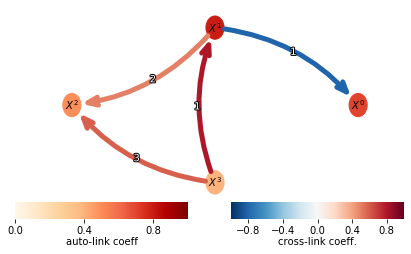

In [59]:
tp.plot_graph(
    val_matrix=val_matrix,
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-link coeff.',
    node_colorbar_label='auto-link coeff',
    ); plt.show()

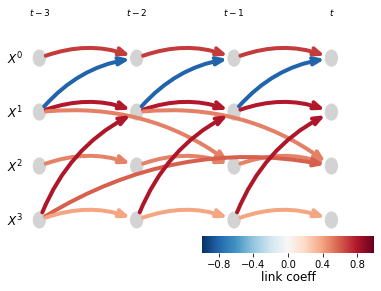

In [60]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=val_matrix,
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='link coeff',
    ); plt.show()

In [64]:
all_parents = {0: [(3, -2), (1, -2), (0, -1)],
               1: [],
               2: [],
               3: [],
               }
fit_results = model.get_fit(all_parents=all_parents,
                selected_variables=[0],
                tau_max=None,
                cut_off='max_lag_or_tau_max',
                return_data=False)
coefs = model.get_coefs()
print(coefs)

{0: {(3, -2): -0.64590114, (1, -2): -0.63967484, (0, -1): 0.70020694}}


While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off. You can adjust the size and aspect ratio of nodes with `node_size` and `node_aspect` parameters, and also modify many other properties, see the parameters of `plot_graph` and `plot_time_series_graph`.

## 2. Estimating linear total effects

The quantity of interest now is some total effect between $X_{t-\tau}$ and $Y_t$. Here we assume that the user knows which adjustment set to use. 

For example, if we want to estimate the of $X^3_{t-2}$ on $X^0_t$, we need to account for backdoor paths here only through auto-links.

In [23]:
all_parents = {0: [(3, -2), (0, -1), (1, -2)],
               1: [],
               2: [],
               3: [],
               }
fit_results = model.get_fit(all_parents=all_parents,
                selected_variables=[0],
                tau_max=None,
                cut_off='max_lag_or_tau_max',
                return_data=False)
coefs = model.get_coefs()
print(coefs)

{0: {(3, -2): -0.6431109, (0, -1): 0.6989268, (1, -2): -0.6356675}}


## 4. Estimating nonlinear effects with sklearn


In [105]:
model = Models(
        dataframe=dataframe, 
        model=sklearn.linear_model.LinearRegression(),
        data_transform=None,   #sklearn.preprocessing.StandardScaler(),
        mask_type=None,
        verbosity=0)

In [106]:
X = [(3, -2)]
Y = [(0, 0)]
Z = [(0, -1), (1, -2)]
fit_results = model.get_general_fitted_model( 
                Y=Y, X=X, Z=Z)

In [107]:
intervention_array_0 = np.copy(data)
intervention_data_0 = pp.DataFrame(intervention_array_0)

intervention_array_1 = np.copy(data)
# Set X = [(3, -2)] to x+1
intervention_array_1[:,3] += 1.
intervention_data_1 = pp.DataFrame(intervention_array_1)


prediction_0 = model.get_general_prediction(
                Y=Y, X=X, Z=Z,
                intervention_data=intervention_data_0)
print(prediction_0)
prediction_1 = model.get_general_prediction(
                Y=Y, X=X, Z=Z,
                intervention_data=intervention_data_1)
print(prediction_1)

{(0, 0): array([  3.5258794, -13.552127 , -45.914627 , ...,  16.50327  ,
        27.391775 ,  23.476685 ], dtype=float32)}
{(0, 0): array([-11.25845  , -28.336456 , -60.698956 , ...,   1.7189384,
        12.607444 ,   8.692355 ], dtype=float32)}


In [108]:
# The linear coefficient is equal to the expectation of the difference of these two interventions
print(np.mean(prediction_1[Y[0]]-prediction_0[Y[0]]))

-14.78433


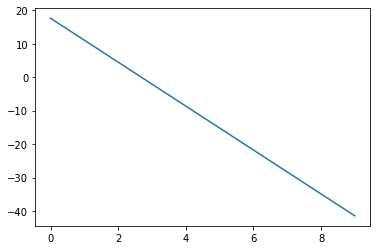

In [109]:
X_intervention = np.linspace(-2, 2, 10)

prediction = np.zeros(len(X_intervention))
for index, x in enumerate(X_intervention):
    intervention_array_1 = np.copy(data)
    intervention_array_1[:,3] = x
    intervention_data_1 = pp.DataFrame(intervention_array_1)

    prediction_1 = model.get_general_prediction(
                    Y=Y, X=X, Z=Z,
                    intervention_data=intervention_data_1)
    prediction[index] = np.mean(prediction_1[Y[0]])
plt.plot(prediction)

But now you can also use more complex sklearn models.

In [110]:
import sklearn.neighbors
model = Models(
        dataframe=dataframe, 
        model=sklearn.neighbors.KNeighborsRegressor(),
        data_transform=None,
        mask_type=None,
        verbosity=0)

In [111]:
X = [(3, -2)]
Y = [(0, 0)]
Z = [(0, -1), (1, -2)]
fit_results = model.get_general_fitted_model( 
                Y=Y, X=X, Z=Z)

In [112]:
intervention_array_0 = np.copy(data)
intervention_data_0 = pp.DataFrame(intervention_array_0)

intervention_array_1 = np.copy(data)
# Set X = [(3, -2)] to x+1
intervention_array_1[:,3] += 1.
intervention_data_1 = pp.DataFrame(intervention_array_1)

prediction_0 = model.get_general_prediction(
                Y=Y, X=X, Z=Z,
                intervention_data=intervention_data_0)
print(prediction_0)
prediction_1 = model.get_general_prediction(
                Y=Y, X=X, Z=Z,
                intervention_data=intervention_data_1)
print(prediction_1)

{(0, 0): array([ 11.857709 ,  -4.1402783, -38.544933 , ...,   2.1793168,
         4.185391 ,   5.319144 ], dtype=float32)}
{(0, 0): array([  9.748444 ,  -9.223071 , -55.613445 , ...,   1.6286663,
         5.128834 ,   5.202862 ], dtype=float32)}


In [113]:
print(np.mean(prediction_1[Y[0]]-prediction_0[Y[0]]))

-7.167591


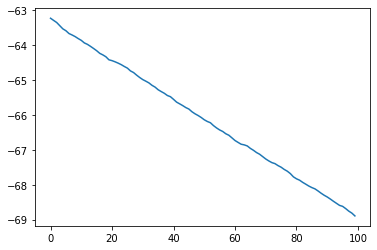

In [119]:
X_intervention = np.linspace(-30+100, 30+100, 100)

prediction = np.zeros(len(X_intervention))
for index, x in enumerate(X_intervention):
    intervention_array_1 = np.copy(data)
    intervention_array_1[:,3] = x
    intervention_data_1 = pp.DataFrame(intervention_array_1)

    prediction_1 = model.get_general_prediction(
                    Y=Y, X=X, Z=Z,
                    intervention_data=intervention_data_1)
    prediction[index] = np.mean(prediction_1[Y[0]])
plt.plot(prediction)

## 5. Generating the ground truth causal effect by intervening in original causal model

In [ ]:

def your_model(intervene_on=None, intervention_value=0.):
    random_state = np.random.RandomState(seed=42)

    def lin(x): return x
    def nonlin(x): return x**3
    T = 1000

    noise = random_state.randn(T, 4)
    # Initialize data as noise and then overwrite (except for first 10 samples)
    data = np.copy(noise)
    for t in range(10, T):
        data[t, 0] = 0.7*lin(data[t-1, 0]) - 0.8*nonlin(data[t-1, 1]) + noise[t,0]
        data[t, 1] = 0.8*lin(data[t-1, 1]) + 0.8*lin(data[t-1, 3]) + noise[t,1]
        data[t, 2] = 0.5*lin(data[t-1, 2]) + 0.5*lin(data[t-2, 1]) + 0.6*lin(data[t-3, 3]) + noise[t,2]
        data[t, 3] = 0.4*lin(data[t-1, 3]) + noise[t,3]
        
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)


## 4. Getting optimal adjustment sets
